**Name:** Alex Medina

**File:** Comprehensive Test

## **SECTION 0:** Setup

In [1]:
import os
os.environ['picaso_refdata'] = r'C:\Users\Alex\Desktop\Picaso\picaso\reference' #THIS MUST GO BEFORE YOUR IMPORT STATEMENT
os.environ['PYSYN_CDBS'] = r'C:\Users\Alex\Desktop\Picaso\grp\redcat\trds' #this is for the stellar data discussed below.

#General
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import sys
import os
import json
from pathlib import Path

# Picaso
from picaso import justdoit as jdi
from picaso import justplotit as jpi

# Virga
from virga import justdoit as vj
from virga import justplotit as cldplt

# Other
from bokeh.models import Legend
from bokeh.plotting import show, figure
from bokeh.palettes import Category10
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## **SECTION 1:** Helper methods

In [15]:
# FOR FUTURE INTERPOLATING PICKLE VALUES
def interpl(P_bar, T_K, **kwargs):
    """
    TP override/modifier (FUTURE):
    - TODAY: return inputs unchanged.
    - LATER: drop in your interpolation-to-higher-res or apply a pickle modifier.
    """
    return P_bar, T_K

In [16]:
# Selecting clouds instead of harcoding cloud species
# Select using virga condensation

def autoselect_clouds(P_bar, T_K, mmw, p_cutoff=1e-2):
    """
    Pick condensates present somewhere above ~10 mbar (P >= p_cutoff).
    """

    cloud_species = ["Al2O3","Cr","Fe","H2O","KCl","Mg2SiO4",
                     "MgSiO3","MnS","NH3","Na2S","ZnS"]
    
    P = np.asarray(P_bar, float)
    T = np.asarray(T_K,   float)

    sel = []
    for sp in cloud_species:
        # Returns condensation T at each P
        _, Tcond = vj.condensation_t(sp, 1.0, mmw, pressure=P)

        # Builds a boolean mask of “valid” levels to check
        # Only deeper than p_cut
        # Where T and Tcond are both finite
        mask = (P >= p_cutoff) & np.isfinite(T) & np.isfinite(Tcond)

        # Test if there exists at least 1 level where atmosphere is
        # Cold enough to condense
        # I.e. if there are any T < Tcond
        # The condensate can forn in the column
        if mask.any() and np.any(T[mask] <= Tcond[mask]):
            # Cloud species added to profile
            sel.append(sp)
    return sel

# Cloud selection depends on MMW, but I feel that I am making loops here
def compute_mmw(profile_dict, fallback=2.36):
    """
    Computing mmw from Sonora profile if present; else use solar mmw.
    """
    mu = profile_dict.get("mu") or profile_dict.get("MU")
    if mu is None:
        return float(fallback)
    mu = np.asarray(mu, float)
    if mu.ndim == 0:
        return float(mu)
    return float(np.mean(mu))

# To randomly sample gravity, fsed and kzz
def rng_uniform(rng, lo, hi, size):
    return rng.uniform(lo, hi, size=size)

def rng_log_uniform(rng, lo, hi, size):
    # Sample uniformly in log10 space
    return 10.0 ** rng.uniform(np.log10(lo), np.log10(hi), size=size)

# To have a specific filename structure
def make_case_filename(Teff, gravity, kzz, fsed, output_dir, ext=".npz"):
    # Whether cloud or clear case
    cloud_tag = "clouds"
    base = f"T{int(round(Teff))}G{int(round(gravity))}{cloud_tag}"

    base += f"_Kzz{float(kzz):.2e}"
    base += f"_fsed{float(fsed):.2f}"

    return os.path.join(output_dir, base + ext)

# Save all files in one place
def make_master_filename(n_spectra, waverange, R, output_dir, clouds=True, ext=".npz"):
    cloud_tag = "clouds" if clouds else "clear"
    # Encode basic config in the filename
    wmin, wmax = waverange
    base = f"N{n_spectra}_R{int(R)}_{wmin:.2f}-{wmax:.2f}um_{cloud_tag}"
    return os.path.join(output_dir, base + ext)

**SECTION 2:** Main function

In [17]:
def bd_spectrum(waverange, gravity, Teff, kzz, fsed, mh, R,
                opacity_db, sonora_db, virga_db):
    """
    Compute a BD emission spectrum with optional Virga clouds.
    """

    # Opacity & inputs
    opa = jdi.opannection(wave_range=list(waverange), filename_db=opacity_db)
    bd = jdi.inputs(calculation="browndwarf")

    # Basic inputs
    bd.phase_angle(0)
    bd.gravity(gravity, gravity_unit=u.Unit('m/s**2'))
    bd.sonora(sonora_db, Teff)


    # Inject Kzz (must match pressure grid length)
    prof = bd.inputs['atmosphere']['profile']
    P = np.asarray(prof["pressure"], float)
    T = np.asarray(prof["temperature"], float)
    mmw = compute_mmw(prof)
    
    bd.inputs["atmosphere"]["profile"]["kz"] = [float(kzz)] * len(P)
    
    # Clouds
    cloud_list = autoselect_clouds(P, T, mmw)
    bd.virga(cloud_list, virga_db, fsed=float(fsed), mh=mh, mmw=mmw)

    out = bd.spectrum(opa, full_output=True)

    # Convert to F_nu, then regrid to constant R in wavenumber
    wn, th = out["wavenumber"], out["thermal"] # [cm^-1], [erg/cm^2/s/cm]
    wl = 1e4/wn
    flamy  = th * 1e-8                                # erg/cm^2/s/Å

    sp = jdi.psyn.ArraySpectrum(wl, flamy,
                                waveunits='um',
                                fluxunits='FLAM')
    
    sp.convert('um')
    sp.convert('Fnu')  # erg/cm^2/s/Hz
    wn, th = sp.wave, sp.flux

    # regrid in wavenumber to constant resolving power R
    out['fluxnu'] = th

    wn, th = jdi.mean_regrid(1e4/wn, th, R=R) #wavenumber, erg/cm2/s/Hz
    out['regridy'] =  th
    out['regridx'] = wn
    
    return wn, th

**SECTION 3:** Configuration

In [18]:
# For sampling
seed = 2

# Directories
input_dir  = r"C:\Users\Alex\Desktop\Picaso\data\sonora" # Sonora db
virga_dir  = r"C:\Users\Alex\Desktop\Picaso\data\virga" # Virga
opacit_dir = None # Opacity db
# Will change once runninng on Newton
# r"/groups/tkaralidi/opacity_500k_for_R5000_egpoutput.db"
output_dir = r"C:\Users\Alex\Desktop\Picaso\outputs" # Output store

# Ensure output dir
os.makedirs(output_dir, exist_ok=True)

use_clouds = True # Clouds on/off

# Wavelength and resolution
wav_range       = (0.3, 3.0) # microns
res_R           = 300 # Can change once opacity and TP change

# Cloud microphysics
MH              = 1.0   # [M/H] metallicity factor ~ solar

# Sampling
N_spectra       = 5 # Number of spectra to generate for sampling
seed            = 2

Teff_range      = (700, 1400)     # K
gravity_range   = (50.0, 1500.0)  # m/s^2
fsed_range      = (0.5, 5.0)      # dimensionless
Kzz_range       = (1e8, 3e10)     # cm^2/s (log-uniform typical for BD)

# Knobs
save_per_case   = True   # Also save per-spectrum files with friendly names
kzz_loguniform  = True   # Log-uniform sampling for Kzz (typical)
VERBOSE         = True

**SECTION 4:** Execute

In [19]:
def generate():

    rng = np.random.default_rng(seed)

    # Draw n samples of Teff, gravity, fsed, kz
    Teff = np.linspace(Teff_range[0], Teff_range[1], num=N_spectra, dtype=float)
    grav = rng_uniform(rng, *gravity_range, size=N_spectra)  # m/s^2
    fsed = rng_uniform(rng, *fsed_range, size=N_spectra)

    if kzz_loguniform:
        kzz  = rng_log_uniform(rng, *Kzz_range, size=N_spectra)   # cm^2/s
    else:
        kzz  = rng_uniform(rng, *Kzz_range, size=N_spectra)       # cm^2/s

    # First run to lock in the grid 
    lam0, f0 = bd_spectrum(waverange=wav_range,
                          gravity=float(grav[0]),
                          Teff=float(Teff[0]),
                          kzz=float(kzz[0]),
                          fsed=float(fsed[0]),
                          mh=float(MH),
                          R=int(res_R),
                          opacity_db=opacit_dir,
                          sonora_db=input_dir,
                          virga_db=virga_dir)
    
    # Checks that every run used the same wavelength grid
    nlam = lam0.size

    # Allocate arrays
    # X holds [Teff, g (m/s^2), f_sed, Kz (cm^2/s)]
    X = np.zeros((N_spectra, 4), dtype=float)          # [Teff, g, fsed, Kzz]
    Y = np.zeros((N_spectra, nlam), dtype=float)       # flux_nu
    lam_master = lam0.copy()

    for i in range(N_spectra):
        lam, fnu = bd_spectrum(waverange=wav_range,
                                  gravity=float(grav[i]),
                                  Teff=float(Teff[i]),
                                  kzz=float(kzz[i]),
                                  fsed=float(fsed[i]),
                                  mh=float(MH),
                                  R=int(res_R),
                                  opacity_db=opacit_dir,
                                  sonora_db=input_dir,
                                  virga_db=virga_dir)
        
        # sanity: ensure same grid
        if lam.shape != lam_master.shape or not np.allclose(lam, lam_master, rtol=0, atol=1e-10):
            # regrid onto master lam if needed
            # (lam may differ slightly from the probe run due to numeric edges)
            from scipy.interpolate import interp1d
            f = interp1d(lam, fnu, kind='linear', bounds_error=False, fill_value=np.nan)
            fnu = f(lam_master)
            lam = lam_master

        X[i] = [Teff[i], grav[i], fsed[i], kzz[i]]
        Y[i] = fnu

        if save_per_case:
            tag_cloud = "clouds"
            fname = f"T{int(round(Teff[i]))}_G{int(round(grav[i]))}_{tag_cloud}_Kzz{kzz[i]:.2e}_fsed{fsed[i]:.2f}_i{i:03d}.npz"
            fpath = str(Path(output_dir, fname))
            np.savez_compressed(fpath,
                                x=np.array([Teff[i], grav[i], fsed[i], kzz[i]], dtype=float),
                                y=fnu.astype(float),
                                wavelength_um=lam.astype(float))
            print(f"[saved] {fpath}")
    
    meta = dict(
        R=res_R,
        waverange=wav_range,
        MH=MH,
        N_spectra=N_spectra,
        seed=seed,
        Teff_range=Teff_range,
        gravity=gravity_range,
        fsed_range=fsed_range,
        Kzz_range=Kzz_range,
        kzz_loguniform=kzz_loguniform
    )
    master_npz = str(Path(output_dir, f"MASTER_T{Teff_range[0]}-{Teff_range[1]}_N{N_spectra}_{'clouds'}_R{res_R}.npz"))
    np.savez_compressed(master_npz,
                        x=X.astype(float),
                        y=Y.astype(float),
                        wavelength_um=lam_master.astype(float),
                        meta_json=json.dumps(meta, indent=2),
                        inputs=np.array(['Teff_K','g_m_s2','fsed','Kzz_cm2s'], dtype=object))

    with open(master_npz.replace(".npz", "_meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    # pretty print (wavelength readable spacing)
    lam_str = np.array2string(lam_master, precision=4, separator=' ', threshold=20)
    print("\n[MASTER SAVED]:", master_npz)
    print("X shape:", X.shape, " (columns: Teff[K], g[m/s^2], f_sed[-], Kzz[cm^2/s])")
    print("Y shape:", Y.shape, " (flux_nu per spectrum)")
    print("λ shape:", lam_master.shape, " (micron)")
    print("λ preview:", lam_str[:300], " ...")

    return dict(X=X, Y=Y, lam_um=lam_master, meta=meta, path=master_npz)

In [20]:
if __name__ == "__main__":
    _ = generate()

[saved] C:\Users\Alex\Desktop\Picaso\outputs\T700_G429_clouds_Kzz2.47e+09_fsed3.78_i000.npz
[saved] C:\Users\Alex\Desktop\Picaso\outputs\T875_G483_clouds_Kzz2.35e+08_fsed1.35_i001.npz
[saved] C:\Users\Alex\Desktop\Picaso\outputs\T1050_G1231_clouds_Kzz1.18e+09_fsed0.75_i002.npz
[saved] C:\Users\Alex\Desktop\Picaso\outputs\T1225_G183_clouds_Kzz4.55e+09_fsed1.74_i003.npz
[saved] C:\Users\Alex\Desktop\Picaso\outputs\T1400_G920_clouds_Kzz1.12e+09_fsed3.46_i004.npz

[MASTER SAVED]: C:\Users\Alex\Desktop\Picaso\outputs\MASTER_T700-1400_N5_clouds_R300.npz
X shape: (5, 4)  (columns: Teff[K], g[m/s^2], f_sed[-], Kzz[cm^2/s])
Y shape: (5, 691)  (flux_nu per spectrum)
λ shape: (691,)  (micron)
λ preview: [ 3336.3158  3347.4555  3358.6323 ... 33055.9841 33166.3547 33277.0937]  ...


**SECTION 5:** Visualizations

In [29]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- CONFIG -----
# Point this to either a per-case file OR a MASTER file
npz_path = Path(r"C:\Users\Alex\Desktop\Picaso\outputs\T1225_G183_clouds_Kzz4.55e+09_fsed1.74_i003.npz")
show_legend_max = 10   # don't make a giant legend if many spectra
to_Flambda = False     # set True to plot Fλ instead of Fν

# Speed of light in micron/s (for Fν -> Fλ)
C_MICRON_S = 2.99792458e14

data = np.load(npz_path)
print("Keys:", list(data.keys()))


Keys: ['x', 'y', 'wavelength_um']


In [30]:
x_raw = data["x"]
y_raw = data["y"]
lam   = data["wavelength_um"].astype(float)  # ensure np.array

# Normalize shapes to batch form
if x_raw.ndim == 1:
    # per-case file: x=(4,), y=(n_lambda,)
    X = x_raw[None, :].astype(float)
    Y = y_raw[None, :].astype(float)
else:
    # MASTER file: x=(N,4), y=(N,n_lambda)
    X = x_raw.astype(float)
    Y = y_raw.astype(float)

n_spectra, n_cols = X.shape
assert n_cols == 4, f"Expected 4 inputs per spectrum, got {n_cols}"
print(f"X shape: {X.shape}  (columns: Teff[K], g[m/s^2], f_sed[-], Kzz[cm^2/s])")
print(f"Y shape: {Y.shape}  (flux_nu per spectrum)")
print(f"λ shape: {lam.shape} (micron)")

# Stats/ranges
Teff = X[:,0]; g = X[:,1]; fsed = X[:,2]; Kzz = X[:,3]
print("\nInput ranges:")
print(f"  Teff [K]   : {float(Teff.min()):.1f} to {float(Teff.max()):.1f}")
print(f"  g [m/s^2]  : {float(g.min()):.2f} to {float(g.max()):.2f}")
print(f"  f_sed [-]  : {float(fsed.min()):.2f} to {float(fsed.max()):.2f}")
print(f"  Kzz [cm^2/s]: {float(Kzz.min()):.3e} to {float(Kzz.max()):.3e}")

print("\nFlux stats across all spectra:")
print(f"  min: {float(Y.min()):.6e}  max: {float(Y.max()):.6e}")

X shape: (1, 4)  (columns: Teff[K], g[m/s^2], f_sed[-], Kzz[cm^2/s])
Y shape: (1, 691)  (flux_nu per spectrum)
λ shape: (691,) (micron)

Input ranges:
  Teff [K]   : 1225.0 to 1225.0
  g [m/s^2]  : 183.28 to 183.28
  f_sed [-]  : 1.74 to 1.74
  Kzz [cm^2/s]: 4.549e+09 to 4.549e+09

Flux stats across all spectra:
  min: 1.362485e-19  max: 4.622891e-07


In [31]:
# Build a DataFrame of inputs for quick inspection
df_inputs = pd.DataFrame(X, columns=["Teff_K", "g_mps2", "f_sed", "Kzz_cm2s"])
df_inputs.index.name = "spectrum_idx"
display(df_inputs.head(min(10, n_spectra)))

# Optional conversion to Fλ
if to_Flambda:
    # Fλ = Fν * c / λ^2, with c in micron/s and λ in micron -> Fλ units follow from your Fν units
    lam2 = lam[None, :]  # broadcast
    Y_plot = Y * (C_MICRON_S / (lam2**2))
    y_label = "Flux (Fλ)"
else:
    Y_plot = Y
    y_label = "Flux (Fν)"

,Teff_K,g_mps2,f_sed,Kzz_cm2s
spectrum_idx,,,,
0,1225.0,183.278116,1.737362,4.549153e+09


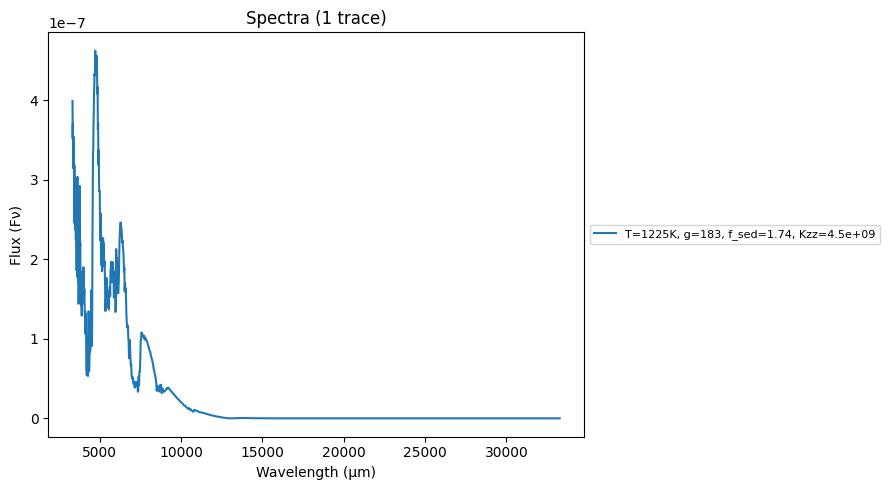

In [32]:
# Plot
plt.figure(figsize=(9,5))
lines_plotted = 0
for i in range(n_spectra):
    teff_i, g_i, fsed_i, kz_i = X[i]
    lbl = f"T={teff_i:.0f}K, g={g_i:.0f}, f_sed={fsed_i:.2f}, Kzz={kz_i:.1e}"
    plt.plot(lam, Y_plot[i], label=lbl if n_spectra <= show_legend_max else None)
    lines_plotted += 1

plt.xlabel("Wavelength (μm)")
plt.ylabel(y_label)
plt.title(f"Spectra ({lines_plotted} trace{'s' if lines_plotted!=1 else ''})")
if n_spectra <= show_legend_max:
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)
plt.tight_layout()
plt.show()